Attempting to load Pen Digits dataset...
Dataset loaded successfully. Shape: (10992, 17)

--- Basic Data Analytics ---
First 5 rows:
   Attribute_1  Attribute_2  Attribute_3  Attribute_4  Attribute_5  \
0           47          100           27           81           57   
1            0           89           27          100           42   
2            0           57           31           68           72   
3            0          100            7           92            5   
4            0           67           49           83          100   

   Attribute_6  Attribute_7  Attribute_8  Attribute_9  Attribute_10  \
0           37           26            0            0            23   
1           75           29           45           15            15   
2           90          100          100           76            75   
3           68           19           45           86            34   
4          100           81           80           60            60   

   Attribute_11  At

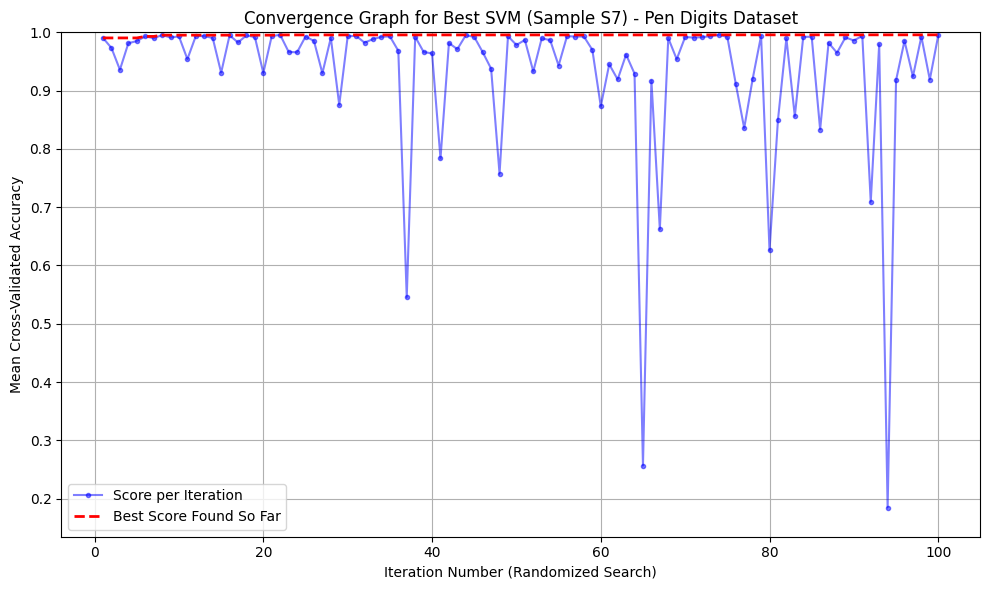


--- GitHub Showcase ---
Remember to showcase the complete results on GitHub:
1. Create a new repository or use an existing one.
2. Upload this Python script.
3. Upload the generated results table (e.g., save results_df to a CSV file).
4. Upload the generated convergence plot PNG file.
5. Add a README.md file explaining the project, dataset (Pen Digits), steps taken, and discussing the results.
   - Include the basic data analytics performed earlier in the README.
   - Discuss the performance variations across different samples.
   - Explain the convergence graph.

Results table saved to 'svm_optimization_results_pendigits.csv'


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # LabelEncoder not needed for this dataset
from sklearn.metrics import accuracy_score
from scipy.stats import expon, loguniform, uniform
import matplotlib.pyplot as plt
import time
import warnings
from urllib.error import URLError


warnings.filterwarnings('ignore')


TRAIN_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
TEST_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"


N_SAMPLES = 10
TEST_SIZE = 0.30
N_ITER_SEARCH = 100 
CV_FOLDS = 5 


print("Attempting to load Pen Digits dataset...")
try:
 
    col_names = [f'Attribute_{i}' for i in range(1, 17)] + ['Class']


    df_train = pd.read_csv(TRAIN_URL, header=None, names=col_names)
    df_test = pd.read_csv(TEST_URL, header=None, names=col_names)

    df = pd.concat([df_train, df_test], ignore_index=True)

    print(f"Dataset loaded successfully. Shape: {df.shape}")

except URLError as e:
    print(f"Error loading dataset from URL: {e}")
    print("Please check the URLs or your internet connection.")

    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    exit()


print("\n--- Basic Data Analytics ---")
print("First 5 rows:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())
print("\nClass Distribution (Digits 0-9):")

print(df['Class'].value_counts().sort_index())


print("\n--- Preprocessing ---")

X = df.drop('Class', axis=1)
y = df['Class'] 


# --- 4 & 5. SVM Optimization Loop ---
results = []
search_history = {} # To store search scores for plotting

print(f"\n--- Starting SVM Optimization for {N_SAMPLES} Samples ---")

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': loguniform(1e-1, 1e3), 
    'gamma': loguniform(1e-4, 1e-1), 
    'kernel': ['rbf'] 

}

start_total_time = time.time()

for i in range(N_SAMPLES):
    sample_start_time = time.time()
    print(f"\nProcessing Sample {i+1}/{N_SAMPLES}...")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=i, stratify=y
    )


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    svm = SVC(probability=False)


    cv_strategy = StratifiedKFold(n_splits=CV_FOLDS)
    random_search = RandomizedSearchCV(
        estimator=svm,
        param_distributions=param_dist,
        n_iter=N_ITER_SEARCH,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        random_state=i,
        verbose=0
    )

  
    print(f"  Running RandomizedSearchCV (n_iter={N_ITER_SEARCH}, cv={CV_FOLDS})...")
    search_start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    search_end_time = time.time()
    print(f"  Search completed in {search_end_time - search_start_time:.2f} seconds.")


    best_svm = random_search.best_estimator_
    y_pred = best_svm.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)


    best_params = random_search.best_params_
    results.append({
        'Sample #': f'S{i+1}',
        'Best Accuracy': accuracy,
        'Best Kernel': best_params.get('kernel', 'N/A'),
        'Best C': best_params.get('C', 'N/A'),
        'Best Gamma': best_params.get('gamma', 'N/A') if best_params.get('kernel') == 'rbf' else 'N/A'
    })


    search_history[f'S{i+1}'] = random_search.cv_results_['mean_test_score']

    sample_end_time = time.time()
    print(f"  Sample {i+1} Best Accuracy: {accuracy:.4f}")
    print(f"  Best Parameters: {best_params}")
    print(f"  Sample processing time: {sample_end_time - sample_start_time:.2f} seconds.")

end_total_time = time.time()
print(f"\n--- Optimization Complete ---")
print(f"Total processing time: {end_total_time - start_total_time:.2f} seconds.")


results_df = pd.DataFrame(results)
results_df = results_df[['Sample #', 'Best Accuracy', 'Best Kernel', 'Best C', 'Best Gamma']]
results_df['Best Accuracy'] = results_df['Best Accuracy'].map('{:.4f}'.format)

print("\n--- Comparative Performance (Table 1) ---")
print(results_df.to_string(index=False))


results_df['Best Accuracy'] = results_df['Best Accuracy'].astype(float)
best_sample_row = results_df.loc[results_df['Best Accuracy'].idxmax()]
best_sample_id = best_sample_row['Sample #']
max_accuracy = best_sample_row['Best Accuracy']

print(f"\n--- Plotting Convergence for Best Sample ({best_sample_id}) ---")
print(f"Highest accuracy achieved: {max_accuracy:.4f}")

best_sample_scores = search_history[best_sample_id]
running_max_score = np.maximum.accumulate(best_sample_scores)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_ITER_SEARCH + 1), best_sample_scores, 'bo-', markersize=3, alpha=0.5, label='Score per Iteration')
plt.plot(range(1, N_ITER_SEARCH + 1), running_max_score, 'r--', linewidth=2, label='Best Score Found So Far')
plt.title(f'Convergence Graph for Best SVM (Sample {best_sample_id}) - Pen Digits Dataset')
plt.xlabel('Iteration Number (Randomized Search)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.ylim(bottom=max(0, np.min(best_sample_scores) - 0.05), top=min(1.0, np.max(best_sample_scores) + 0.01)) # Adjust y-axis
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_filename = f'convergence_graph_sample_{best_sample_id}_pendigits.png'
plt.savefig(plot_filename)
print(f"Convergence plot saved as '{plot_filename}'")
plt.show()

csv_filename = 'svm_optimization_results_pendigits.csv'
results_df['Best Accuracy'] = results_df['Best Accuracy'].map('{:.4f}'.format)
results_df.to_csv(csv_filename, index=False)
print(f"\nResults table saved to '{csv_filename}'")